# Blocks Classification Dataset

## Some Information on this Dataset

There are 10 features in that describe blocks of documents:
   - height: Height of the block.
   - lenght: Length of the block.
   - area: Area of the block (height * lenght);
   - eccen: Eccentricity of the block (lenght / height);
   - p_black: Percentage of black pixels within the block (blackpix / area);
   - p_and: Percentage of black pixels after the application of the Run Length Smoothing Algorithm (RLSA) (blackand / area);
   - mean_tr: Mean number of white-black transitions (blackpix / wb_trans);
   - blackpix: Total number of black pixels in the original bitmap of the block.
   - blackand: Total number of black pixels in the bitmap of the block after the RLSA.
   - wb_trans: Number of white-black transitions in the original bitmap of the block.

There are 5473 examples coming from 54 distinct documents and each observation concerns one block.

The problem consists in classifying all the blocks of the page layout of a document that has been detected by a segmentation process. This is an essential step in document analysis in order to separate text from graphic areas. There are five classes:
 - Text (1),
 - Horizontal line (2),
 - Picture (3),
 - Vertical line (4)
 - Graphic (5).

I will check that the information is correct. And then, I will get other information in applying analysis on the different features such as:
- Type of problem (regression or classification),
- Which feature is the target,
- Type of the different features + some statistics,
- Checking the quality of the dataset.

## Requirements

In [222]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Sklearn: Metrics
from sklearn import tree, metrics
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_absolute_error, mean_squared_error

# Sklearn: Models
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Data Collection

In [165]:
# Getting data and applying the right columns on the dataframe
df_data = pd.read_csv('data/page-blocks.data', sep=r"\s+",names=['Height', 'Length', 'Area', 'Eccen', 'P_Black', 'P_And', 'Mean_Tr', 'Blackpix', 'Blanckand', 'WB_Trans', 'Class'])
df_data

,Height,Length,Area,Eccen,P_Black,P_And,Mean_Tr,Blackpix,Blanckand,WB_Trans,Class
0,5,7,35,1.400,0.400,0.657,2.33,14,23,6,1
1,6,7,42,1.167,0.429,0.881,3.60,18,37,5,1
2,6,18,108,3.000,0.287,0.741,4.43,31,80,7,1
3,5,7,35,1.400,0.371,0.743,4.33,13,26,3,1
4,6,3,18,0.500,0.500,0.944,2.25,9,17,4,1
...,...,...,...,...,...,...,...,...,...,...,...
5468,4,524,2096,131.000,0.542,0.603,40.57,1136,1264,28,2
5469,7,4,28,0.571,0.714,0.929,10.00,20,26,2,1
5470,6,95,570,15.833,0.300,0.911,1.64,171,519,104,1
5471,7,41,287,5.857,0.213,0.801,1.36,61,230,45,1


## First Exploratory Data Analysis (EDA)

In [166]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5473 entries, 0 to 5472
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Height     5473 non-null   int64  
 1   Length     5473 non-null   int64  
 2   Area       5473 non-null   int64  
 3   Eccen      5473 non-null   float64
 4   P_Black    5473 non-null   float64
 5   P_And      5473 non-null   float64
 6   Mean_Tr    5473 non-null   float64
 7   Blackpix   5473 non-null   int64  
 8   Blanckand  5473 non-null   int64  
 9   WB_Trans   5473 non-null   int64  
 10  Class      5473 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 470.5 KB


In [167]:
df_data.describe()

,Height,Length,Area,Eccen,P_Black,P_And,Mean_Tr,Blackpix,Blanckand,WB_Trans,Class
count,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000,5473.000000
mean,10.473232,89.568244,1198.405628,13.753977,0.368642,0.785053,6.219278,365.930751,741.108167,106.662891,1.202631
std,18.960564,114.721758,4849.376950,30.703737,0.177757,0.170661,69.079021,1270.333082,1881.504302,167.308362,0.721470
min,1.000000,1.000000,7.000000,0.007000,0.052000,0.062000,1.000000,7.000000,7.000000,1.000000,1.000000
25%,7.000000,17.000000,114.000000,2.143000,0.261000,0.679000,1.610000,42.000000,95.000000,17.000000,1.000000
50%,8.000000,41.000000,322.000000,5.167000,0.337000,0.803000,2.070000,108.000000,250.000000,49.000000,1.000000
75%,10.000000,107.000000,980.000000,13.625000,0.426000,0.927000,3.000000,284.000000,718.000000,126.000000,1.000000
max,804.000000,553.000000,143993.000000,537.000000,1.000000,1.000000,4955.000000,33017.000000,46133.000000,3212.000000,5.000000


In [168]:
df_data.describe().T

,count,mean,std,min,25%,50%,75%,max
Height,5473.0,10.473232,18.960564,1.000,7.000,8.000,10.000,804.0
Length,5473.0,89.568244,114.721758,1.000,17.000,41.000,107.000,553.0
Area,5473.0,1198.405628,4849.376950,7.000,114.000,322.000,980.000,143993.0
Eccen,5473.0,13.753977,30.703737,0.007,2.143,5.167,13.625,537.0
P_Black,5473.0,0.368642,0.177757,0.052,0.261,0.337,0.426,1.0
P_And,5473.0,0.785053,0.170661,0.062,0.679,0.803,0.927,1.0
Mean_Tr,5473.0,6.219278,69.079021,1.000,1.610,2.070,3.000,4955.0
Blackpix,5473.0,365.930751,1270.333082,7.000,42.000,108.000,284.000,33017.0
Blanckand,5473.0,741.108167,1881.504302,7.000,95.000,250.000,718.000,46133.0
WB_Trans,5473.0,106.662891,167.308362,1.000,17.000,49.000,126.000,3212.0


In the .name file that accompanied the .data file, there are some statistical metrics. We can see that we have the same results. So the reading of the data was good and the implementaton of the names for each column was accurate too.

In [169]:
df_data['Class'].unique()

array([1, 2, 4, 5, 3], dtype=int64)

So we do have 9 features, each of them numerical ones.

We have a target, named 'Class' with 5 categories distincts as the description said. So we have here a supervised problem.


What is the problem?
With the information gathered above, we want to classify blocks of a page layout of a document. We want here the prediction of a class so we can conclude this is a classification problem.

## Data Preprocessing

### Missing Values

First, let's check if there are missing values in this dataset. If so, I will have to either drop the feature if it has too many missing values or if not, I will have to apply some technique of data augmentation.

In [170]:
df_data.isna().sum()

Height       0
Length       0
Area         0
Eccen        0
P_Black      0
P_And        0
Mean_Tr      0
Blackpix     0
Blanckand    0
WB_Trans     0
Class        0
dtype: int64

There are no missing values in this dataset, which is a good thing.

### Null and Zero Values

In [171]:
df_data.isnull().sum()

Height       0
Length       0
Area         0
Eccen        0
P_Black      0
P_And        0
Mean_Tr      0
Blackpix     0
Blanckand    0
WB_Trans     0
Class        0
dtype: int64

In [172]:
values_tot = len(df_data.index)
df_data[df_data == 0].count()/values_tot

Height       0.0
Length       0.0
Area         0.0
Eccen        0.0
P_Black      0.0
P_And        0.0
Mean_Tr      0.0
Blackpix     0.0
Blanckand    0.0
WB_Trans     0.0
Class        0.0
dtype: float64

I wanted to see the proportion of null values for each feature. We do not have any null or zero values.

### Outliers

Outliers are observations that can be interpreted as data that deviates quite noticeably from other observations in a sample.

Sometimes, those outliers are shown as bad data in the dataset: we can either drop them or arrange them. But in some other cases, it may not be possible to determine if an outlying point is bad data, because it can be due to random variation or indicate something scientifically interesting.

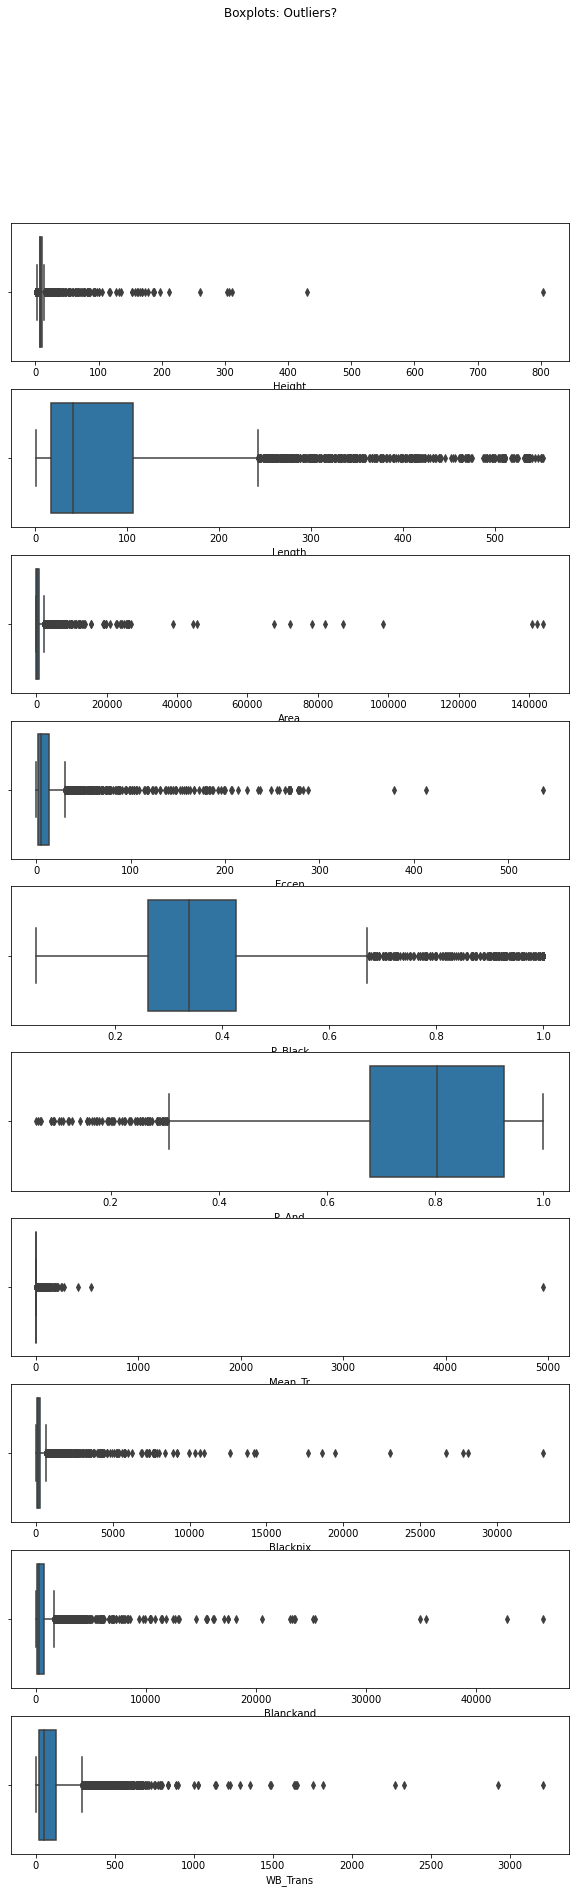

In [173]:
fig, ax = plt.subplots(10, 1, figsize=(10, 30))
fig.suptitle('Boxplots: Outliers?')

sns.boxplot(data=df_data, x=df_data['Height'], ax=ax[0])
sns.boxplot(data=df_data, x=df_data['Length'], ax=ax[1])
sns.boxplot(data=df_data, x=df_data['Area'], ax=ax[2])
sns.boxplot(data=df_data, x=df_data['Eccen'], ax=ax[3])
sns.boxplot(data=df_data, x=df_data['P_Black'], ax=ax[4])
sns.boxplot(data=df_data, x=df_data['P_And'], ax=ax[5])
sns.boxplot(data=df_data, x=df_data['Mean_Tr'], ax=ax[6])
sns.boxplot(data=df_data, x=df_data['Blackpix'], ax=ax[7])
sns.boxplot(data=df_data, x=df_data['Blanckand'], ax=ax[8])
sns.boxplot(data=df_data, x=df_data['WB_Trans'], ax=ax[9])

plt.show()

We can see thanks to these boxplots that we have a lot of outliers for several features. Let's finish our checks before reflecting on either we treat those outliers or not.

### Categorical Features

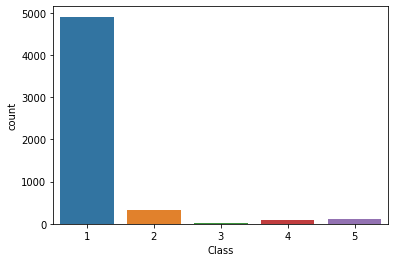

In [174]:
sns.countplot(x='Class', data=df_data)
plt.show()

In [175]:
print(f"Proportion of text in the target: {round(df_data['Class'][df_data['Class']==1].count()/len(df_data) * 100, 2)}%")

Proportion of text in the target: 89.77%


As we can see here, only one category is well representing. So to get a better classification in the future, we can see if we can gathered the 4 other classes togther:
- Text (1): Kept the same category, the first one from the previous,
- Graphical (0): Gathered the 2th, 3th, 4th and 5th categories together.

In [176]:
test = df_data['Class'].apply(lambda x: 0 if x in [2, 3, 4, 5] else 1)
test.value_counts()

1    4913
0     560
Name: Class, dtype: int64

Even if we combine several class together, we can't match the amount of data we have for the first class (text).

## Imbalanced Class & Outliers Management

We have three solutions:
- We can drop randomly a part of the data that are from the first class to balance the classes,
- We can analyse the outliers and see if they are from the first class. If so, we delete those ones to balance the classes,
- We do not touch anything and analyse how the models will be biaised and will overfit with this dataset.

Let's take a look at the outliers is this dataset.

First we create a new dataframe without the target.

In [177]:
df_viz_w_target = df_viz[['Height', 'Length', 'Area', 'Eccen', 'P_Black', 'P_And', 'Mean_Tr', 'Blackpix', 'Blanckand', 'WB_Trans']]

I will use the interquatiles method to detect and to get the outliers to treat. This method is really usefull and easy to use.
The interquartile gives indication about how the data is spread around the median.

How does it work?
- First we calculate the interquartile range,
- Then we multiply the interquartile range by 1.5 which is a constant that will help us to detect the outliers,
- After that we add this multiplication to the third quartile and we subtract the multiplication to the first quartile,

If any data are higher than the new third quartile or lower than the new first quartile, they are considered as outliers.
We do this operation for each feature of this dataset.

In [178]:
def interquartile_rule(df_data):
    n = len(df_data.columns.tolist())
    for i, col in enumerate(df_data.columns):
        percentile25 = df_data[col].quantile(0.25)
        percentile75 = df_data[col].quantile(0.75)
        iqr = percentile75 - percentile25

        upper_limit = percentile75 + 1.5 * iqr
        lower_limit = percentile25 - 1.5 * iqr

        new_df_data = df_data[(df_data[col] < upper_limit) & (df_data[col] > lower_limit)]
    return new_df_data

In [179]:
new_df_viz = interquartile_rule(df_viz_w_target)
new_df_viz.describe().T

,count,mean,std,min,25%,50%,75%,max
Height,4920.0,9.306301,15.726478,1.000,7.000,8.000,10.000,804.0
Length,4920.0,62.037602,76.551118,1.000,16.000,35.000,82.250,553.0
Area,4920.0,587.118293,1357.212796,7.000,102.000,264.000,684.000,45760.0
Eccen,4920.0,12.106341,31.565529,0.007,2.000,4.500,10.111,537.0
P_Black,4920.0,0.378593,0.178980,0.052,0.271,0.344,0.433,1.0
P_And,4920.0,0.798460,0.168823,0.062,0.700,0.824,0.937,1.0
Mean_Tr,4920.0,6.526907,72.835902,1.000,1.630,2.080,3.000,4955.0
Blackpix,4920.0,195.736585,493.364240,7.000,38.000,90.000,202.000,10654.0
Blanckand,4920.0,401.696341,642.791638,7.000,86.000,206.000,517.000,12964.0
WB_Trans,4920.0,64.129472,65.698277,1.000,15.000,40.000,91.000,289.0


We can see that this method has a impact on the mean and the std of each feature. But in our case, the interquartile rule has not a big impact.

Let's get a list of each data that have been detected as outliers.

In [180]:
set_ind_outliers = set(df_viz_w_target.index.tolist()) ^ set(new_df_viz.index.tolist())

len(set_ind_outliers)/len(df_viz) * 100

10.104147633838846

We have 10% of the dataset that is considered as outliers by the interquartile rules.

Let's see how those outliers are spread about the different classes.

In [181]:
df_outliers = df_viz[df_viz.index.isin(set_ind_outliers)]
df_outliers['Class'].value_counts()

1    519
5     19
3     14
2      1
Name: Class, dtype: int64

The majority of the outliers comes from the first class that is the most represented class on this dataset.

Based on these results, I will drop only the outliers from the first class and keep the other, knowing that the goal here is both to treat the outliers and the imbalanced classes.

In [182]:
l_ind_outlier_c1 = df_outliers[df_outliers['Class'] == 1].index.tolist()

In [183]:
df_prep = df_viz.copy()
df_prep.drop(df_prep.index[l_ind_outlier_c1], inplace=True)
df_prep

,Height,Length,Area,Eccen,P_Black,P_And,Mean_Tr,Blackpix,Blanckand,WB_Trans,Class
0,5,7,35,1.400,0.400,0.657,2.33,14,23,6,1
1,6,7,42,1.167,0.429,0.881,3.60,18,37,5,1
2,6,18,108,3.000,0.287,0.741,4.43,31,80,7,1
3,5,7,35,1.400,0.371,0.743,4.33,13,26,3,1
4,6,3,18,0.500,0.500,0.944,2.25,9,17,4,1
...,...,...,...,...,...,...,...,...,...,...,...
5468,4,524,2096,131.000,0.542,0.603,40.57,1136,1264,28,2
5469,7,4,28,0.571,0.714,0.929,10.00,20,26,2,1
5470,6,95,570,15.833,0.300,0.911,1.64,171,519,104,1
5471,7,41,287,5.857,0.213,0.801,1.36,61,230,45,1


In [184]:
df_prep['Class'].value_counts()

1    4394
2     329
5     115
4      88
3      28
Name: Class, dtype: int64

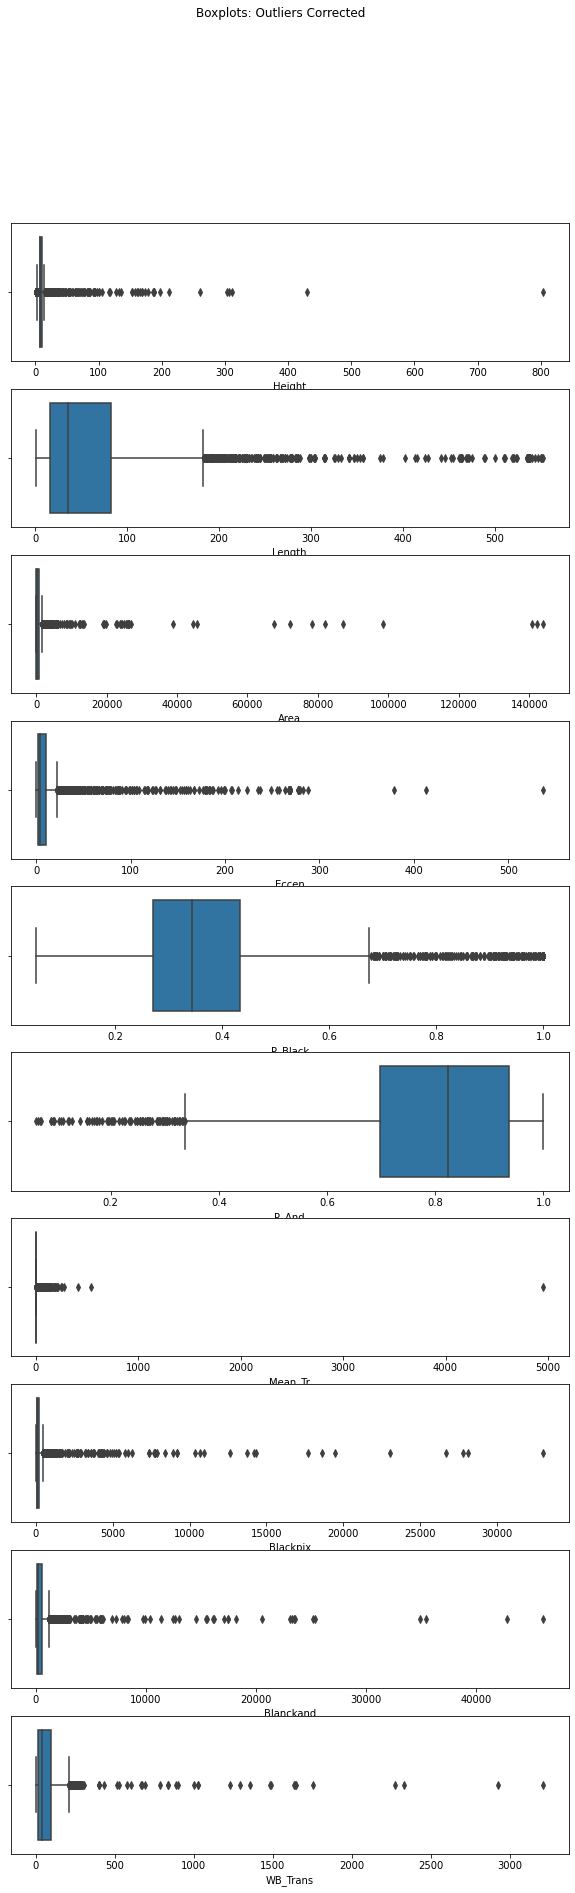

In [185]:
fig, ax = plt.subplots(10, 1, figsize=(10, 30))
fig.suptitle('Boxplots: Outliers Corrected')

sns.boxplot(data=df_prep, x=df_prep['Height'], ax=ax[0])
sns.boxplot(data=df_prep, x=df_prep['Length'], ax=ax[1])
sns.boxplot(data=df_prep, x=df_prep['Area'], ax=ax[2])
sns.boxplot(data=df_prep, x=df_prep['Eccen'], ax=ax[3])
sns.boxplot(data=df_prep, x=df_prep['P_Black'], ax=ax[4])
sns.boxplot(data=df_prep, x=df_prep['P_And'], ax=ax[5])
sns.boxplot(data=df_prep, x=df_prep['Mean_Tr'], ax=ax[6])
sns.boxplot(data=df_prep, x=df_prep['Blackpix'], ax=ax[7])
sns.boxplot(data=df_prep, x=df_prep['Blanckand'], ax=ax[8])
sns.boxplot(data=df_prep, x=df_prep['WB_Trans'], ax=ax[9])

plt.show()

Now, we will treat the imbalanced class that is still a problem here.

I will take a sample of the data for the first class (1/8).

In [186]:
df_sample = df_prep[df_prep['Class'] == 1]
df_sample = df_sample.sample(frac=0.125)
df_sample

,Height,Length,Area,Eccen,P_Black,P_And,Mean_Tr,Blackpix,Blanckand,WB_Trans,Class
2434,8,23,184,2.875,0.359,0.940,1.65,66,173,40,1
2982,10,28,280,2.800,0.343,0.975,2.13,96,273,45,1
4295,10,186,1860,18.600,0.347,0.771,2.42,645,1434,267,1
1267,8,132,1056,16.500,0.360,0.921,2.10,380,973,181,1
3549,8,102,816,12.750,0.403,0.929,2.70,329,758,122,1
...,...,...,...,...,...,...,...,...,...,...,...
1179,7,172,1204,24.571,0.294,0.967,2.07,354,1164,171,1
2213,9,16,144,1.778,0.278,0.917,1.48,40,132,27,1
2204,9,16,144,1.778,0.208,0.715,1.50,30,103,20,1
2902,11,54,594,4.909,0.273,0.781,2.19,162,464,74,1


In [187]:
df_prep_final = pd.concat([df_prep[df_prep['Class'] != 1], df_sample])
df_prep_final

,Height,Length,Area,Eccen,P_Black,P_And,Mean_Tr,Blackpix,Blanckand,WB_Trans,Class
34,3,113,339,37.667,0.410,0.472,13.90,139,160,10,2
35,3,59,177,19.667,0.475,0.475,84.00,84,84,1,2
36,2,20,40,10.000,0.675,0.675,27.00,27,27,1,2
37,2,101,202,50.500,0.540,0.743,10.90,109,150,10,2
43,4,194,776,48.500,0.263,0.273,34.00,204,212,6,2
...,...,...,...,...,...,...,...,...,...,...,...
1179,7,172,1204,24.571,0.294,0.967,2.07,354,1164,171,1
2213,9,16,144,1.778,0.278,0.917,1.48,40,132,27,1
2204,9,16,144,1.778,0.208,0.715,1.50,30,103,20,1
2902,11,54,594,4.909,0.273,0.781,2.19,162,464,74,1


In [188]:
df_prep_final['Class'].value_counts()

1    549
2    329
5    115
4     88
3     28
Name: Class, dtype: int64

We have now a better balance for our classes. Let's move on.

## Second Exploratory Data Analysis (EDA)

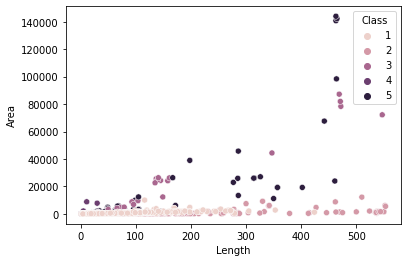

In [189]:
sns.scatterplot(x='Length', y='Area', data=df_prep_final, hue='Class')
plt.show()

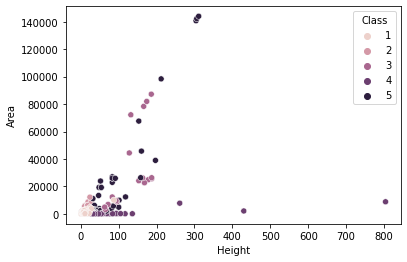

In [192]:
sns.scatterplot(x='Height', y='Area', data=df_prep_final, hue='Class')
plt.show()

### Univariate Analysis

So first, I will make a copy of the previous dataframe to get one for the visualization. I do not need to create new columns. All the features are pretty well as they are right now.

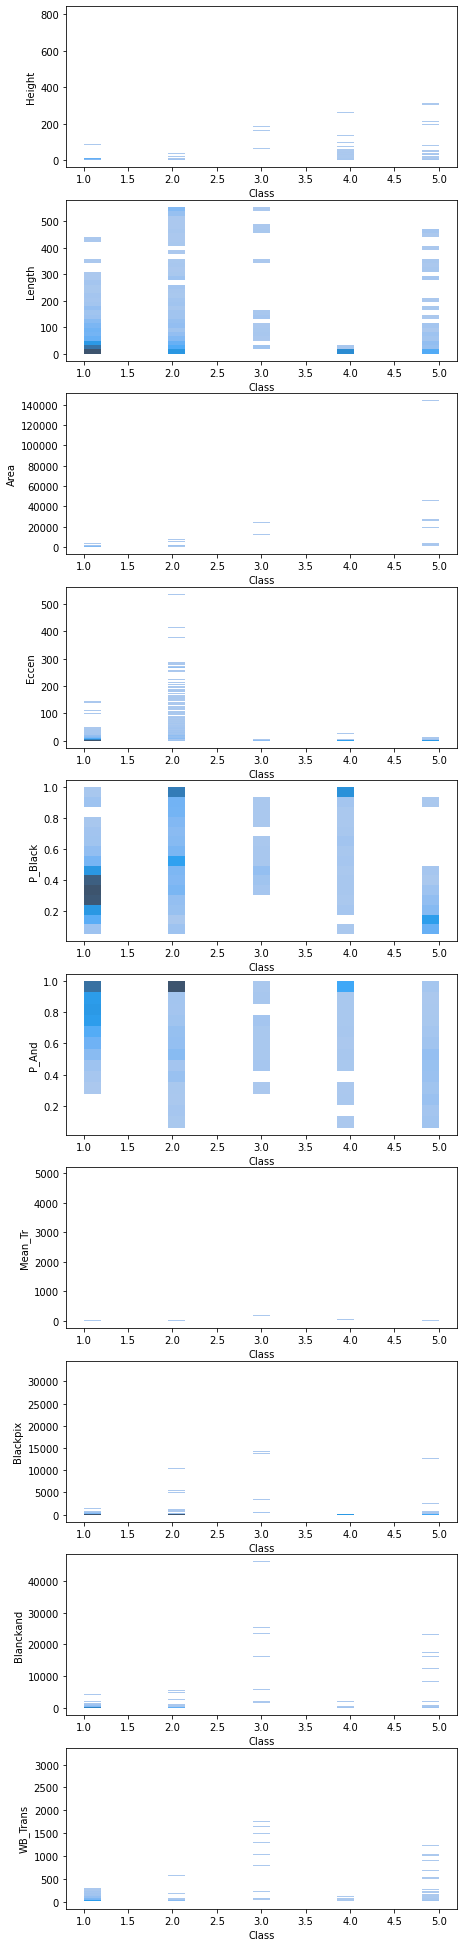

In [193]:
fig, ax = plt.subplots(10, 1, figsize=(7, 35))

sns.histplot(x='Class', y='Height', data=df_prep_final, ax=ax[0])
sns.histplot(x='Class', y='Length', data=df_prep_final, ax=ax[1])
sns.histplot(x='Class', y='Area', data=df_prep_final, ax=ax[2])
sns.histplot(x='Class', y='Eccen', data=df_prep_final, ax=ax[3])
sns.histplot(x='Class', y='P_Black', data=df_prep_final, ax=ax[4])
sns.histplot(x='Class', y='P_And', data=df_prep_final, ax=ax[5])
sns.histplot(x='Class', y='Mean_Tr', data=df_prep_final, ax=ax[6])
sns.histplot(x='Class', y='Blackpix', data=df_prep_final, ax=ax[7])
sns.histplot(x='Class', y='Blanckand', data=df_prep_final, ax=ax[8])
sns.histplot(x='Class', y='WB_Trans', data=df_prep_final, ax=ax[9])

plt.show()

### Bivariate Analysis

Let's take a look to multiple pairwise bivariate distributions in this dataset.

<Figure size 720x480 with 0 Axes>

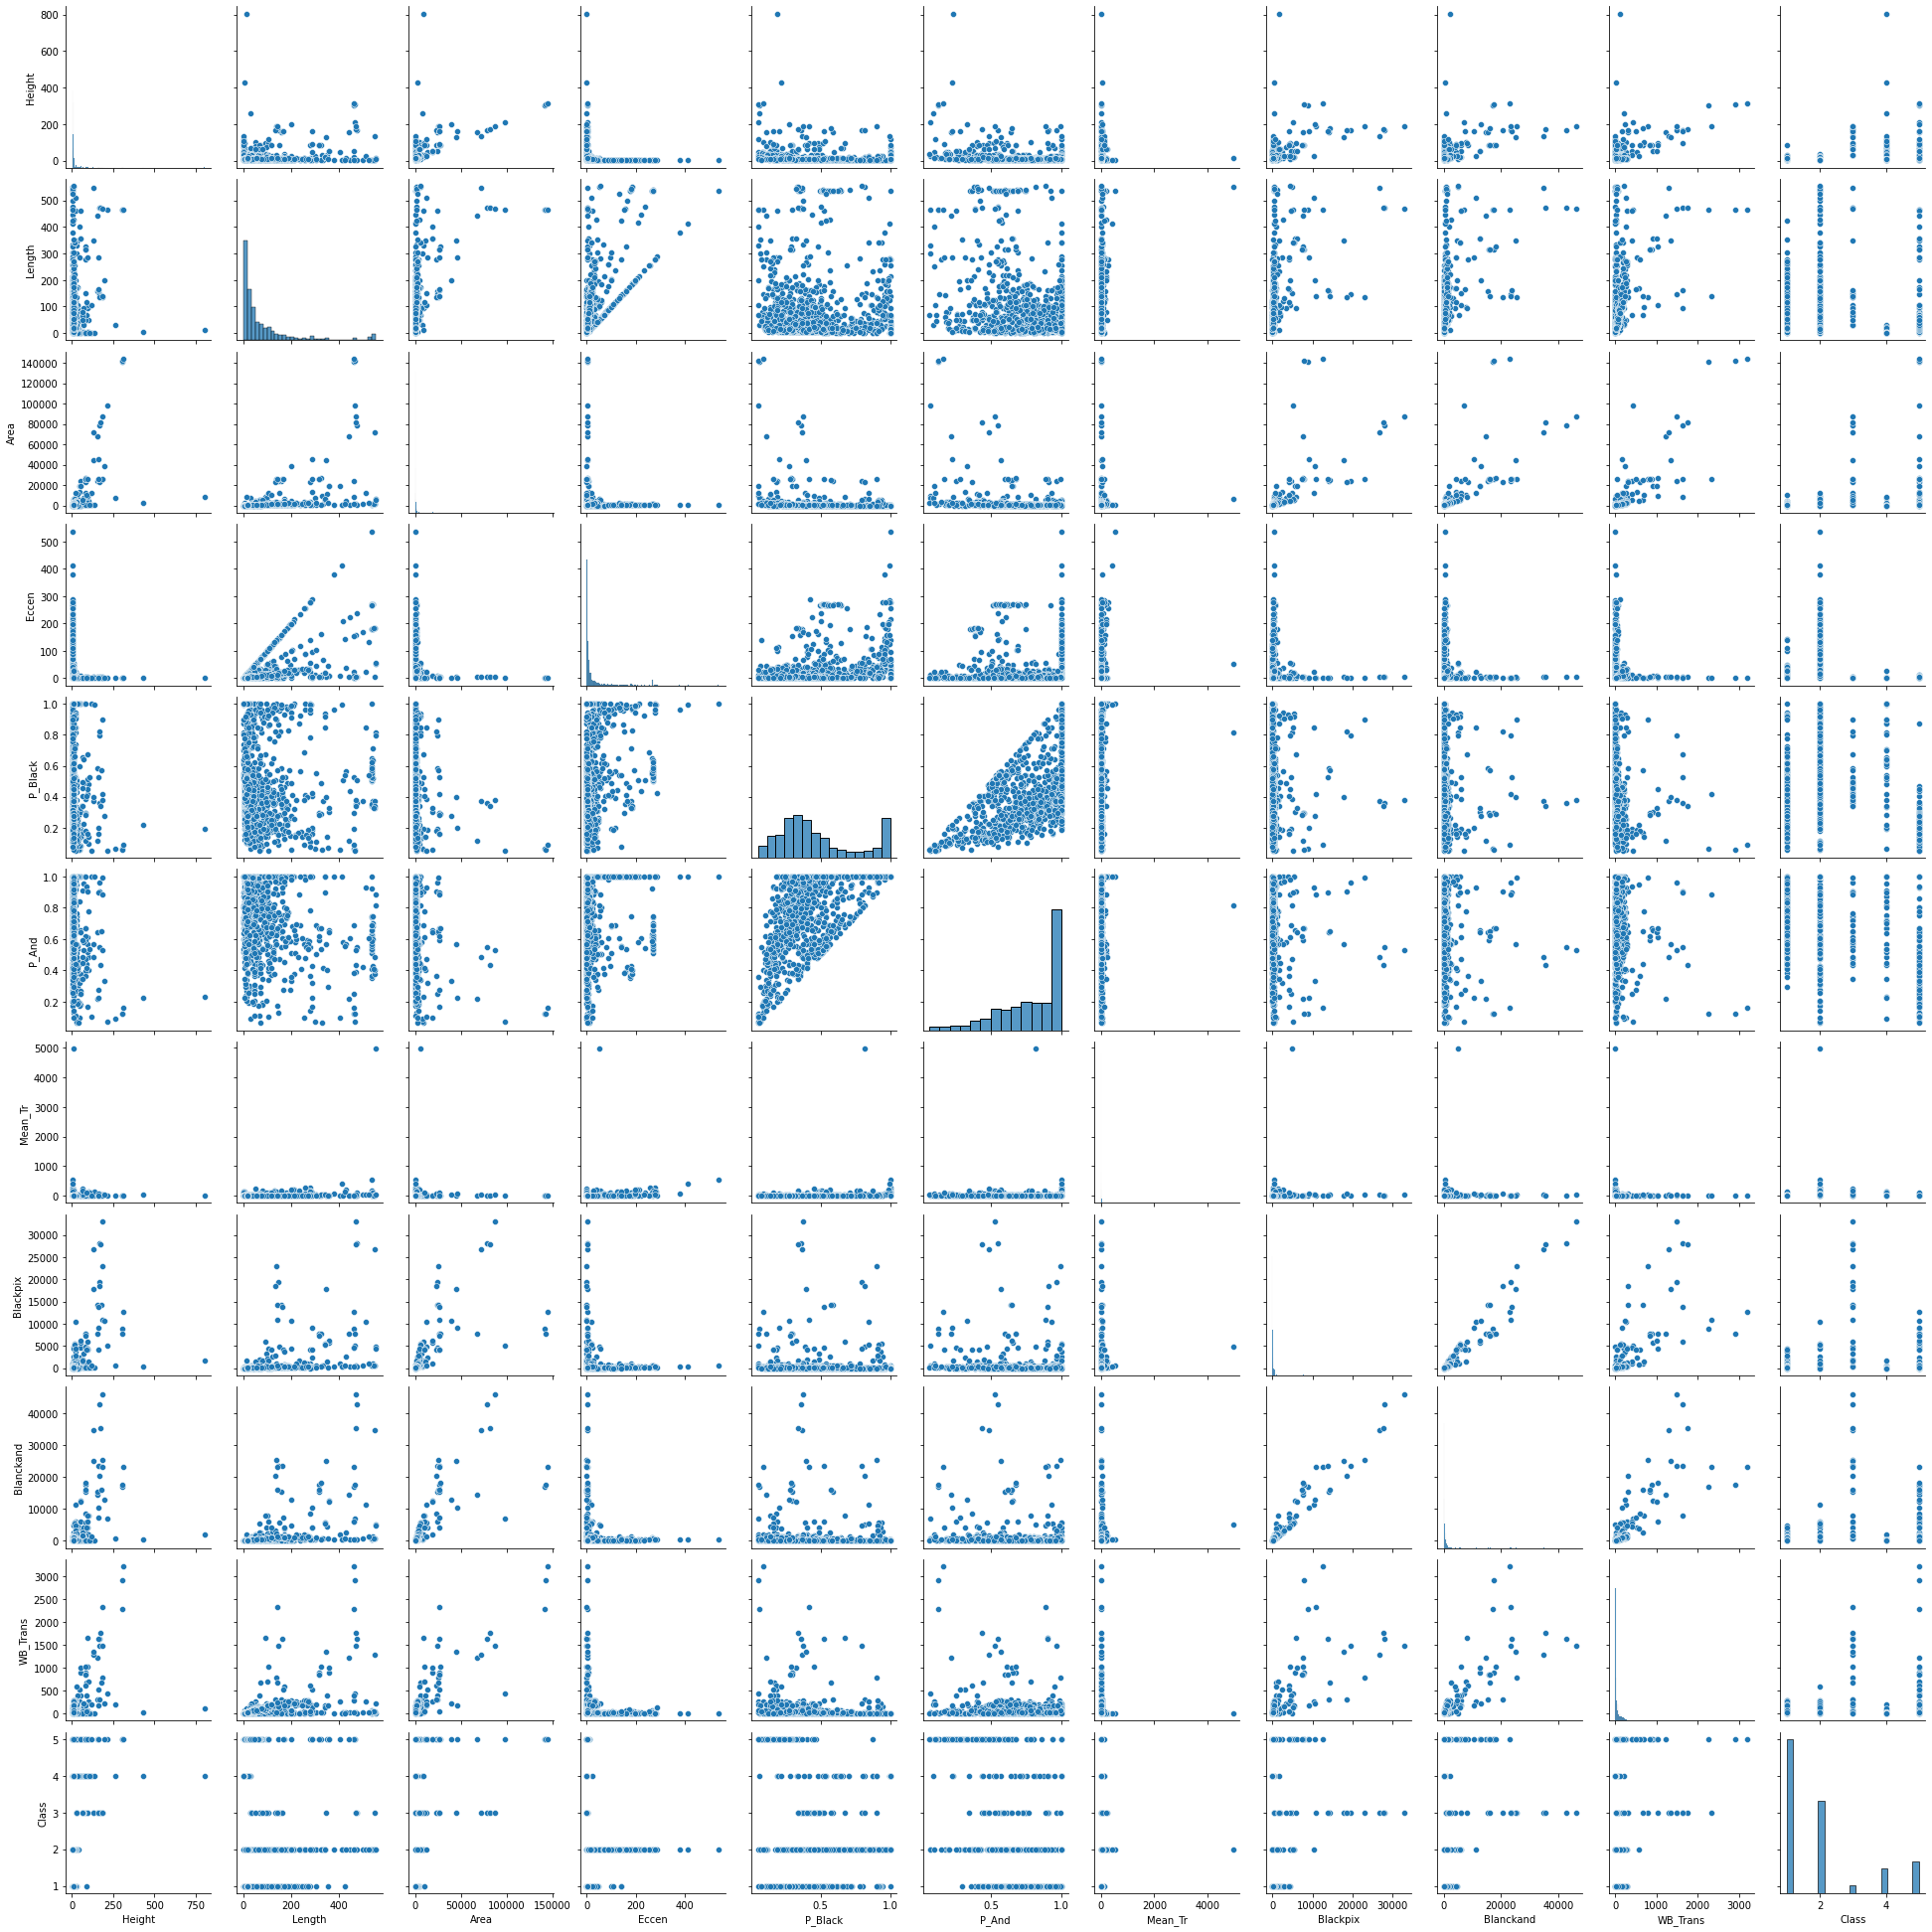

In [194]:
plt.figure(dpi=120)
sns.pairplot(df_prep_final)
plt.show()

### Correlation

To visualize the correlation between each feature, we have to convert categorical features to numeric ones. The function below will do this job.

In [202]:
corr_mat = df_viz.corr()
corr_mat_prep = df_prep_final.corr()

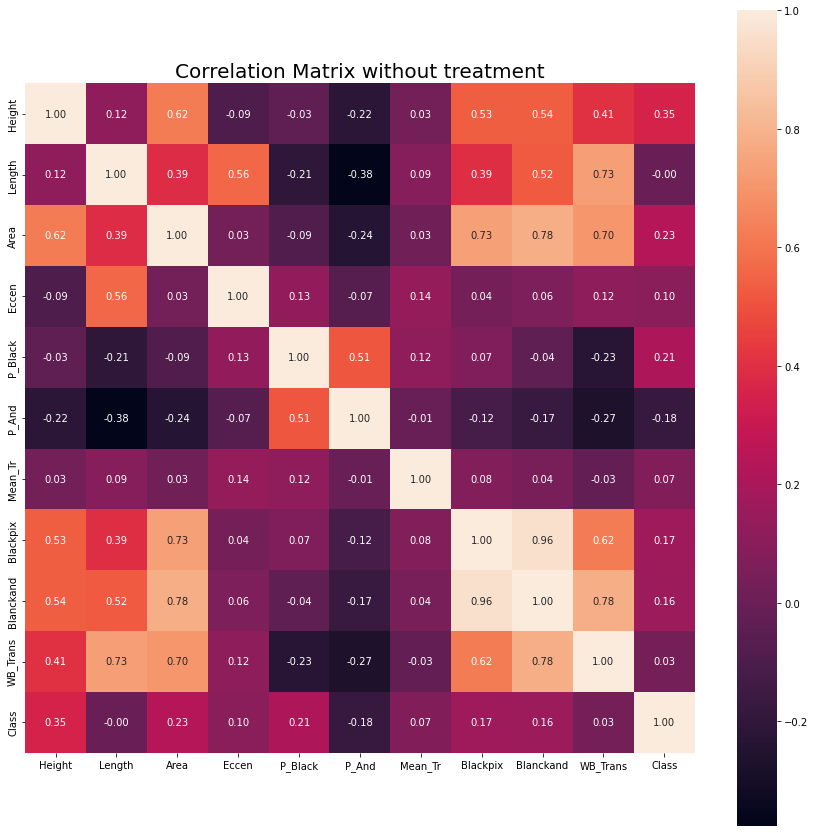

In [203]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_mat, square=True, annot=True, fmt='.2f')
plt.title('Correlation Matrix without treatment', fontsize=20)
plt.show()

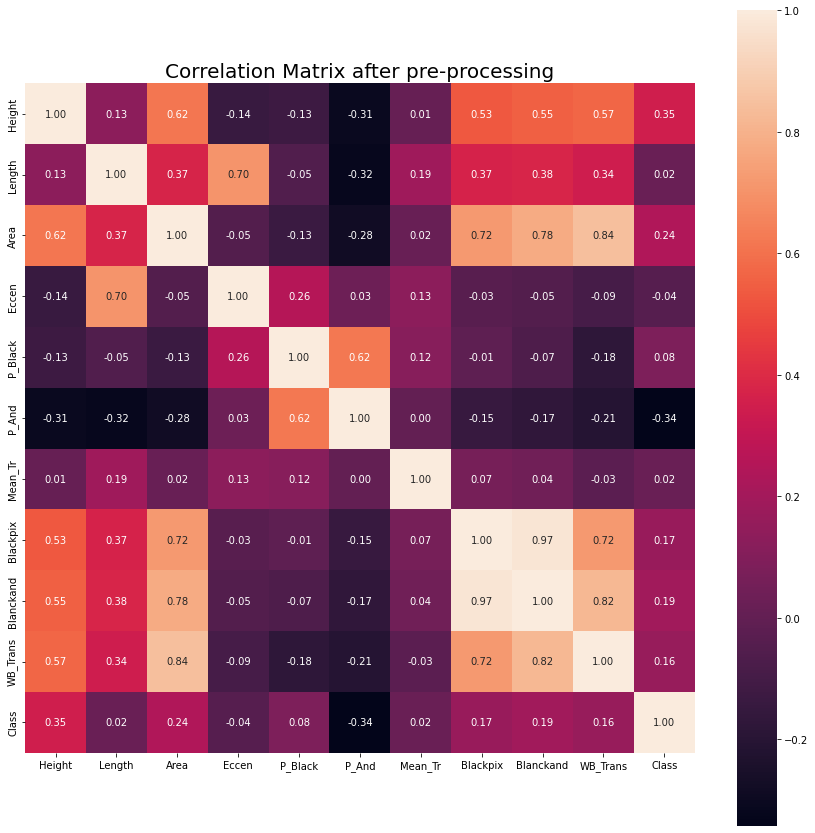

In [204]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_mat_prep, square=True, annot=True, fmt='.2f')
plt.title('Correlation Matrix after pre-processing', fontsize=20)
plt.show()

Here, we can see the correlation between each feature. We can see that several features are correlated with each other. The pre-processing has an impact on the correlation, basically the main ones are between P_Black, P_And, WB_Trans and the target. But because of the fact that

In [207]:
corr_mat_sorted_by_class = corr_mat_prep[['Class']].sort_values(by='Class', ascending=False)

In [212]:
l_significant_features = corr_mat_sorted_by_class.index [corr_mat_sorted_by_class['Class'] > 0.10].tolist()[1::]
l_significant_features

['Height', 'Area', 'Blanckand', 'Blackpix', 'WB_Trans']

## Data Processing & Feature Engineering

### Normalization/Standardization

In [213]:
# Creating a dataframe without the target
df_prep_w_target = df_prep_final[l_significant_features]

In [216]:
X_train, X_test, y_train, y_test = train_test_split(df_prep_w_target, df_prep_final['Class'], test_size=0.30)
X_train

,Height,Area,Blanckand,Blackpix,WB_Trans
5126,9,468,293,95,69
2664,6,84,84,48,21
3725,2,1074,667,558,21
1780,8,432,336,119,87
5358,8,360,260,177,19
...,...,...,...,...,...
4982,91,25935,4287,4100,36
4606,83,26062,16139,7353,838
3553,9,1494,1120,585,190
991,11,781,567,289,120


In [217]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=df_prep_w_target.columns)
X_test = pd.DataFrame(scaler.fit_transform(X_test), columns=df_prep_w_target.columns)

## Models Fitting

In [218]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Linear Discriminant Analysis': LinearDiscriminantAnalysis(),
    'Quadratic Discriminant Analysis': QuadraticDiscriminantAnalysis(),
    'SVM - Classifier': SVC(),
    'Stochastic Gradient Descent Classifier': SGDClassifier(),
    'Naïve Bayes': GaussianNB(),
    'Decision Trees': DecisionTreeClassifier(),
    'Bagging': BaggingClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'Random Forest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
}

In [219]:
df_result = pd.DataFrame(index=list(models.keys()))

### Model Selection: Training and Cross Validation

In [233]:
for f in tqdm(range(5, 21)):
    l_scores = []
    l_roc_auc = []
    for k, v in models.items():
        kfolds = KFold(n_splits=f)
        cross_validation_acc = cross_val_score(v, X_train, y_train, cv=kfolds, scoring='accuracy')
        cross_validation_roc_auc = cross_val_score(v, X_train, y_train, cv=kfolds, scoring='roc_auc')
        l_scores.append(cross_validation_acc.mean())
        l_roc_auc.append(cross_validation_roc_auc.mean())
    df_result.loc[:, f'accuracy_kfold_{f}'] = l_scores
    df_result.loc[:, f'roc_auc_kfold_{f}'] = l_roc_auc

df_result

100%|██████████| 16/16 [00:42<00:00,  2.64s/it]


,accuracy_kfold_5,roc_auc_kfold_5,accuracy_kfold_6,roc_auc_kfold_6,accuracy_kfold_7,roc_auc_kfold_7,accuracy_kfold_8,roc_auc_kfold_8,accuracy_kfold_9,roc_auc_kfold_9,...,roc_auc_kfold_13,accuracy_kfold_14,roc_auc_kfold_14,accuracy_kfold_15,roc_auc_kfold_15,accuracy_kfold_16,accuracy_kfold_17,accuracy_kfold_18,accuracy_kfold_19,accuracy_kfold_20
Logistic Regression,0.829859,NaN,0.826039,NaN,0.831192,NaN,0.831186,NaN,0.833675,NaN,...,NaN,0.831192,NaN,0.833761,NaN,0.829905,0.831202,0.831072,0.829814,0.831174
Linear Discriminant Analysis,0.527039,NaN,0.528384,NaN,0.528337,NaN,0.527062,NaN,0.528335,NaN,...,NaN,0.527110,NaN,0.525867,NaN,0.525856,0.528303,0.525664,0.525738,0.528273
Quadratic Discriminant Analysis,0.782151,NaN,0.762900,NaN,0.784767,NaN,0.771907,NaN,0.779530,NaN,...,NaN,0.773075,NaN,0.779563,NaN,0.777051,0.775675,0.773138,0.775706,0.770513
SVM - Classifier,0.784756,NaN,0.792506,NaN,0.797660,NaN,0.795103,NaN,0.797618,NaN,...,NaN,0.793808,NaN,0.796280,NaN,0.793793,0.796334,0.795073,0.796245,0.796255
Stochastic Gradient Descent Classifier,0.804086,NaN,0.779825,NaN,0.796455,NaN,0.789948,NaN,0.824661,NaN,...,NaN,0.783372,NaN,0.786023,NaN,0.802748,0.784342,0.813073,0.792555,0.800439
Naïve Bayes,0.596683,NaN,0.563139,NaN,0.590137,NaN,0.578608,NaN,0.577059,NaN,...,NaN,0.569434,NaN,0.572272,NaN,0.571057,0.564422,0.570795,0.570988,0.574831
Decision Trees,0.869876,NaN,0.885351,NaN,0.880145,NaN,0.885309,NaN,0.890522,NaN,...,NaN,0.888149,NaN,0.889191,NaN,0.881696,0.885507,0.890445,0.889217,0.877665
Bagging,0.885352,NaN,0.891841,NaN,0.904633,NaN,0.882732,NaN,0.895690,NaN,...,NaN,0.894388,NaN,0.899497,NaN,0.899500,0.898267,0.894321,0.898203,0.885391
AdaBoost,0.713888,NaN,0.636484,NaN,0.710074,NaN,0.688144,NaN,0.689328,NaN,...,NaN,0.686920,NaN,0.694671,NaN,0.679236,0.685592,0.680086,0.680392,0.680398
Random Forest,0.905955,NaN,0.908537,NaN,0.908494,NaN,0.903351,NaN,0.907259,NaN,...,NaN,0.909903,NaN,0.911036,NaN,0.912442,0.907303,0.912409,0.916239,0.907220


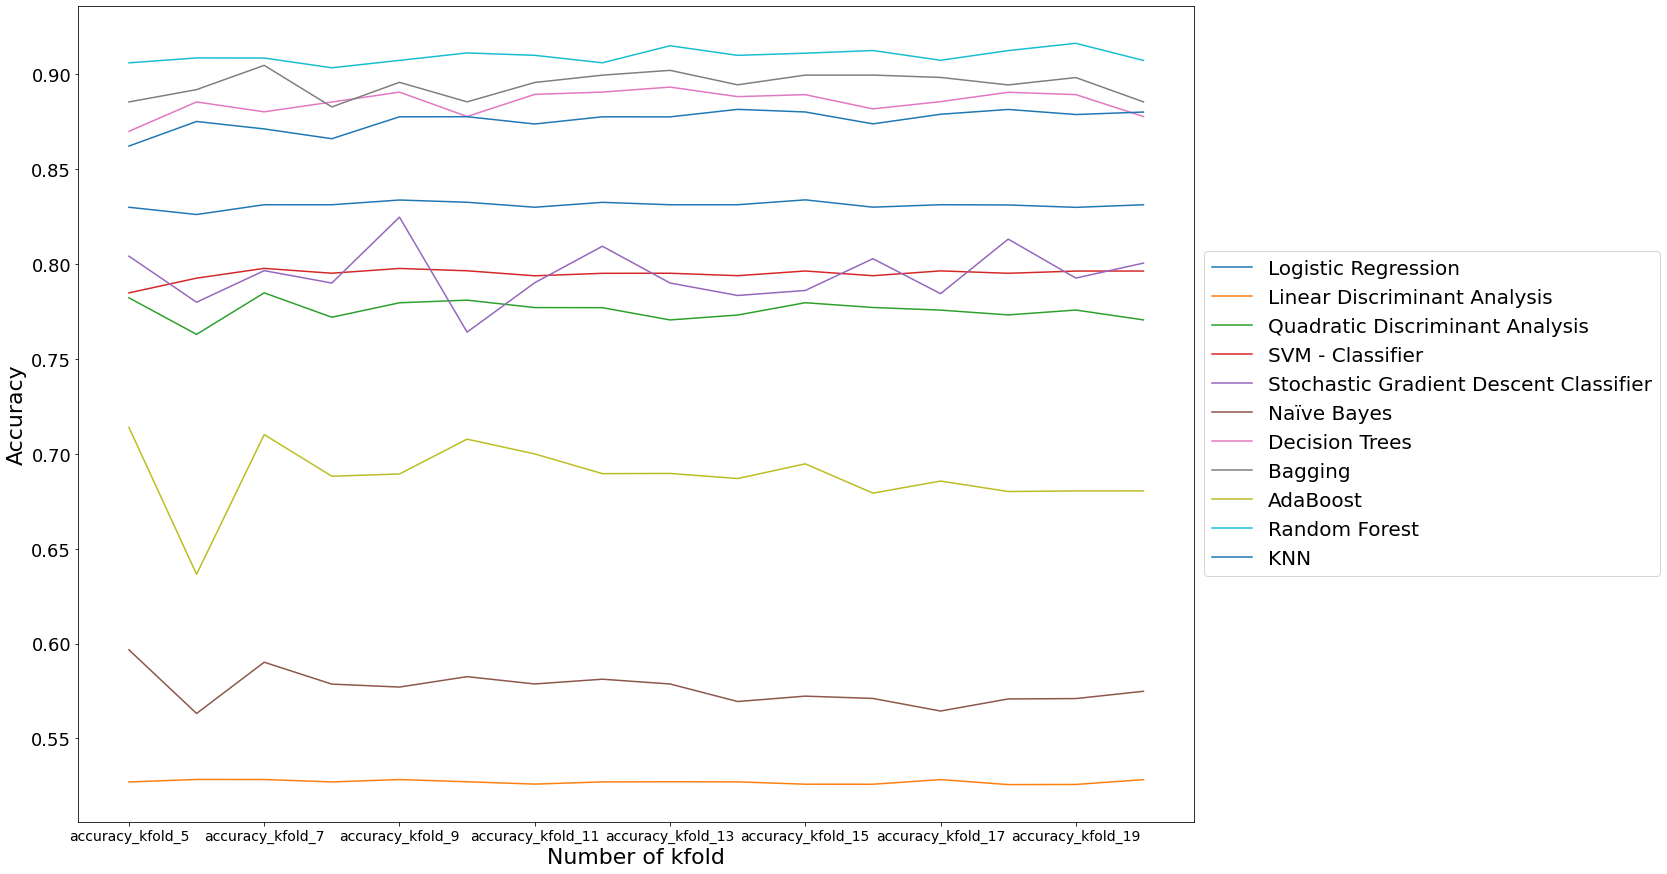

In [258]:
plt.figure(figsize=(20, 15))

l_cols = [col for col in df_result.columns.tolist() if 'accuracy' in col]

for model in df_result.index.tolist():
    df_result.loc[model, l_cols].plot()

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 20})
plt.tick_params(axis='x', labelsize=14)
plt.xlabel('Number of kfold', fontsize=22)
plt.tick_params(axis='y', labelsize=18)
plt.ylabel('Accuracy', fontsize=22)
plt.show()

In [259]:
df_result['accuracy_kfold_10'].sort_values(ascending=False)

Random Forest                             0.911172
Bagging                                   0.885398
Decision Trees                            0.877689
KNN                                       0.877572
Logistic Regression                       0.832501
SVM - Classifier                          0.796387
Quadratic Discriminant Analysis           0.780919
Stochastic Gradient Descent Classifier    0.764069
AdaBoost                                  0.707676
Naïve Bayes                               0.582534
Linear Discriminant Analysis              0.527156
Name: accuracy_kfold_10, dtype: float64

We can see above a rank of the best models for this dataset. I will tune hyperparameters for four models:
- One tree-based model, random forest,
- KNN,
- Logistic Regression,
- SVC.

### Hyperparameters for the selected models

In [298]:
def grid_search_models(model_fitted, params, kfolds):
    grid_search_model = GridSearchCV(model_fitted, param_grid=params, cv=kfolds, n_jobs=-1)
    grid_search_model.fit(X_train, y_train)
    return grid_search_model.best_params_

#### Random Forest

In [351]:
model_rf = RandomForestClassifier()
model_rf.fit(X_train, y_train)
pred_model_rf = model_rf.predict(X_test)
model_rf.score(X_test, y_test)

0.6846846846846847

In [352]:
report_rf = classification_report(y_test, pred_model_rf, output_dict=True)
df_report_rf = pd.DataFrame(report_rf).transpose()
df_report_rf

,precision,recall,f1-score,support
1,0.979381,0.575758,0.725191,165.000000
2,0.575758,0.979381,0.725191,97.000000
3,0.666667,0.166667,0.266667,12.000000
4,0.472222,0.809524,0.596491,21.000000
5,0.593750,0.500000,0.542857,38.000000
accuracy,0.684685,0.684685,0.684685,0.684685
macro avg,0.657556,0.606266,0.571279,333.000000
weighted avg,0.774551,0.684685,0.679744,333.000000


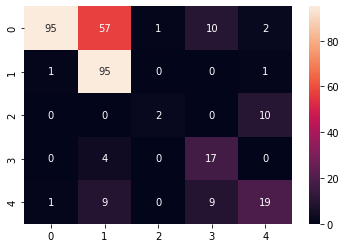

In [353]:
sns.heatmap(confusion_matrix(y_test, pred_model_rf), annot=True, fmt='.0f')
plt.show()

In [274]:
# storing accuracies for training and testing sets from 0% of accuracy
d_train_acc = {0: 0}
d_test_acc = {0: 0}

for d in tqdm(range(1, 101)):
    forest = RandomForestClassifier(max_depth=d)
    forest.fit(X_train, y_train)
    train_predict = forest.predict(X_train)
    test_predict = forest.predict(X_test)
    d_train_acc[d] = accuracy_score(y_train, train_predict)
    d_test_acc[d] = accuracy_score(y_test, test_predict)

100%|██████████| 100/100 [00:11<00:00,  8.63it/s]


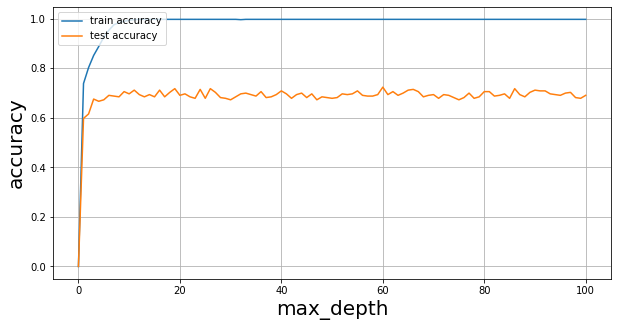

In [275]:
plt.figure(figsize=(10, 5))
plt.plot(list(d_train_acc.values()), label="train accuracy")
plt.plot(list(d_test_acc.values()), label="test accuracy")
plt.legend(loc="upper left")
plt.xlabel("max_depth", size=20)
plt.ylabel("accuracy", size=20)
plt.grid()
plt.show()

In [277]:
max(d_test_acc.values())

0.7237237237237237

In [282]:
for k, v in d_test_acc.items():
    if v == max(d_test_acc.values()):
        print(f'max_depth: {k}')
        print(f'accuracy max for test: {max(d_test_acc.values())}')

max_depth: 60
accuracy max for test: 0.7237237237237237


We have the best score for the test set when max_depth has a value of 60.

As we keep increasing the value of max_depth, the test accuracy remains the same compared to the train accuracy that keeps increasing.

Interpretation: The RandomForestClassifier model keeps learning about the trainsing set when we increase this parameter. However, the accuracy of the test set does not improve at all.

Let's get the hyperparameters.

In [356]:
params_rf = {
    'criterion': ('gini', 'entropy'),
    'n_estimators': [100, 300, 500, 800, 1200],
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 90, 100],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [1, 2, 5, 10]
}

d_best_params_rf = grid_search_models(RandomForestClassifier(), params_rf, 10)
d_best_params_rf

KeyboardInterrupt: 

In [77]:
model_rf2 = RandomForestRegressor(**d_best_params_rf)
model_rf2.fit(X_train, y_train)
pred_model_rf2 = model_rf2.predict(X_test)
model_rf2.score(X_test, y_test)

ValueError: ignored

In [ ]:
report_rf2 = classification_report(y_test, pred_model_rf2, output_dict=True)
df_report_rf2 = pd.DataFrame(report_rf2).transpose()
df_report_rf2

In [ ]:
sns.heatmap(confusion_matrix(y_test, pred_model_rf2), annot=True, fmt='.0f')
plt.show()

#### KNN

In [347]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)
pred_model_knn = model_knn.predict(X_test)
model_knn.score(X_test, y_test)

0.7957957957957958

In [348]:
report_knn1 = classification_report(y_test, pred_model_knn, output_dict=True)
df_report_knn1 = pd.DataFrame(report_knn1).transpose()
df_report_knn1

,precision,recall,f1-score,support
1,0.970588,0.800000,0.877076,165.000000
2,0.712121,0.969072,0.820961,97.000000
3,1.000000,0.500000,0.666667,12.000000
4,0.470588,0.761905,0.581818,21.000000
5,0.680000,0.447368,0.539683,38.000000
accuracy,0.795796,0.795796,0.795796,0.795796
macro avg,0.766660,0.695669,0.697241,333.000000
weighted avg,0.831667,0.795796,0.796027,333.000000


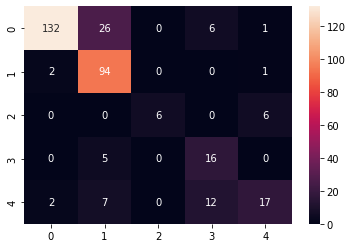

In [349]:
sns.heatmap(confusion_matrix(y_test, pred_model_knn), annot=True, fmt='.0f')
plt.show()

In [ ]:
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix,
                      group_names=labels,
                      categories=categories,
                      cmap='binary')

In [295]:
# storing accuracies for training and testing sets from 0% of accuracy
d_train_knn_acc = {0: 0}
d_test_knn_acc = {0: 0}

for n in tqdm(range(1, 26)):
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    train_predict = knn.predict(X_train)
    test_predict = knn.predict(X_test)
    d_train_knn_acc[n] = accuracy_score(y_train, train_predict)
    d_test_knn_acc[n] = accuracy_score(y_test, test_predict)

100%|██████████| 25/25 [00:00<00:00, 45.76it/s]


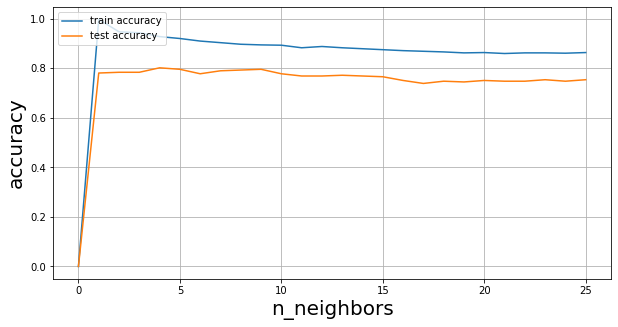

In [296]:
plt.figure(figsize=(10, 5))
plt.plot(list(d_train_knn_acc.values()), label="train accuracy")
plt.plot(list(d_test_knn_acc.values()), label="test accuracy")
plt.legend(loc="upper left")
plt.xlabel("n_neighbors", size=20)
plt.ylabel("accuracy", size=20)
plt.grid()
plt.show()

In [297]:
for k, v in d_test_knn_acc.items():
    if v == max(d_test_knn_acc.values()):
        print(f'n_neighbors: {k}')
        print(f'accuracy max for test: {max(d_test_acc.values())}')

n_neighbors: 4
accuracy max for test: 0.7237237237237237


Let's get the hyperparameters.

In [307]:
params_knn = {
    'algorithm': ('auto', 'ball_tree', 'kd_tree', 'brute'),
    'leaf_size': list(range(1, 50)),
    'n_neighbors': list(range(1, 30)),
    'p': [1,2]
}

d_best_params_knn = grid_search_models(KNeighborsClassifier(), params_knn, 10)
d_best_params_knn

{'algorithm': 'ball_tree', 'leaf_size': 1, 'n_neighbors': 3, 'p': 1}

In [343]:
model_knn2 = KNeighborsClassifier(**d_best_params_knn)
model_knn2.fit(X_train, y_train)
pred_model_knn2 = model_knn2.predict(X_test)
model_knn2.score(X_test, y_test)

0.8048048048048048

With the hyperparameters tune thanks to the GridSearch method, we increase the accuracy test from 0.7237 to 0.8048.

In [344]:
report_knn2 = classification_report(y_test, pred_model_knn2, output_dict=True)
df_report_knn2 = pd.DataFrame(report_knn2).transpose()
df_report_knn2

,precision,recall,f1-score,support
1,0.937063,0.812121,0.870130,165.000000
2,0.706767,0.969072,0.817391,97.000000
3,1.000000,0.500000,0.666667,12.000000
4,0.629630,0.809524,0.708333,21.000000
5,0.708333,0.447368,0.548387,38.000000
accuracy,0.804805,0.804805,0.804805,0.804805
macro avg,0.796359,0.707617,0.722182,333.000000
weighted avg,0.826759,0.804805,0.800517,333.000000


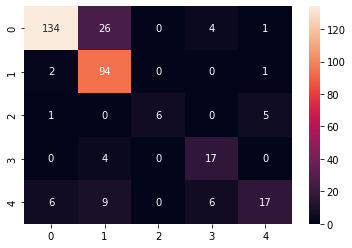

In [345]:
sns.heatmap(confusion_matrix(y_test, pred_model_knn2), annot=True, fmt='.0f')
plt.show()

### SVC

In [326]:
model_svc = SVC()
model_svc.fit(X_train, y_train)
pred_model_svc = model_svc.predict(X_test)
model_svc.score(X_test, y_test)

0.6726726726726727

In [328]:
report_svc1 = classification_report(y_test, pred_model_svc, output_dict=True)
df_report_svc1 = pd.DataFrame(report_svc1).transpose()
df_report_svc1

,precision,recall,f1-score,support
1,0.904348,0.630303,0.742857,165.000000
2,0.545455,0.989691,0.703297,97.000000
3,1.000000,0.083333,0.153846,12.000000
4,0.555556,0.476190,0.512821,21.000000
5,0.565217,0.342105,0.426230,38.000000
accuracy,0.672673,0.672673,0.672673,0.672673
macro avg,0.714115,0.504325,0.507810,333.000000
weighted avg,0.742557,0.672673,0.659469,333.000000


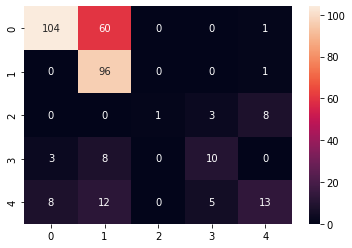

In [331]:
sns.heatmap(confusion_matrix(y_test, pred_model_svc), annot=True, fmt='.0f')
plt.show()

In [336]:
params_svc = {
    'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
    'C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 10, 20, 50, 100, 500],
    'degree': [3, 8],
    'gamma' : [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0],
}

d_best_params_svc = grid_search_models(model_svc, params_svc, 10)
d_best_params_svc

{'C': 500, 'degree': 3, 'gamma': 1, 'kernel': 'linear'}

In [337]:
model_svc2 = SVC(**d_best_params_svc)
model_svc2.fit(X_train, y_train)
pred_model_svc2 = model_svc2.predict(X_test)
model_svc2.score(X_test, y_test)

0.7897897897897898

In [338]:
report_svc2 = classification_report(y_test, pred_model_svc2, output_dict=True)
df_report_svc2 = pd.DataFrame(report_svc2).transpose()
df_report_svc2

,precision,recall,f1-score,support
1,0.969231,0.763636,0.854237,165.00000
2,0.789916,0.969072,0.870370,97.00000
3,1.000000,0.500000,0.666667,12.00000
4,0.352941,0.857143,0.500000,21.00000
5,0.703704,0.500000,0.584615,38.00000
accuracy,0.789790,0.789790,0.789790,0.78979
macro avg,0.763158,0.717970,0.695178,333.00000
weighted avg,0.848941,0.789790,0.799070,333.00000


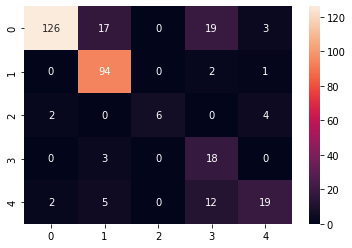

In [340]:
sns.heatmap(confusion_matrix(y_test, pred_model_svc2), annot=True, fmt='.0f')
plt.show()

## Conclusion

...